# Predicting winpercent using BigQuery ML

This notebook illustrates:

1. Machine Learning using BigQuery
2. Jupyter Magic for BigQuery in Cloud Datalab

Please see this notebook for more context on this problem and how the features were chosen.

In [1]:
# change these to try this notebook out
PROJECT = 'lidldatascientistadvanalytics'
REGION = 'us-central1'

In [2]:
import os
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [4]:
%load_ext google.cloud.bigquery
%load_ext google.datalab.kernel

## Exploring the Data

Here, we will be taking natality data and training on features to predict winpercent.

The Ultimate Halloween Candy Power Ranking has details on the best (or at least the most popular) Halloween candy. More details: https://www.kaggle.com/fivethirtyeight/the-ultimate-halloween-candy-power-ranking

Lets start by looking at the data!

In [5]:
%%bq query
SELECT
    competitorname, 
    chocolate, 
    fruity, 
    caramel, 
    peanutyalmondy, 
    nougat, 
    crispedricewafer, 
    hard, 
    bar, 
    pluribus, 
    sugarpercent, 
    pricepercent, 
    winpercent
FROM
  lidldatascientistadvanalytics.candy_data.original
ORDER BY winpercent DESC
LIMIT 10

competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
ReeseÕs Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.72000003,0.65100002,84.18029
ReeseÕs Miniatures,1,0,0,1,0,0,0,0,0,0.034000002,0.27900001,81.866257
Twix,1,0,1,0,0,1,0,1,0,0.546,0.90600002,81.642914
Kit Kat,1,0,0,0,0,1,0,1,0,0.31299999,0.51099998,76.7686
Snickers,1,0,1,1,1,0,0,1,0,0.546,0.65100002,76.673782
ReeseÕs pieces,1,0,0,1,0,0,0,0,1,0.40599999,0.65100002,73.43499
Milky Way,1,0,1,0,1,0,0,1,0,0.60399997,0.65100002,73.099556
ReeseÕs stuffed with pieces,1,0,0,1,0,0,0,0,0,0.98799998,0.65100002,72.887901
Peanut butter M&MÕs,1,0,0,1,0,0,0,0,1,0.82499999,0.65100002,71.46505
Nestle Butterfinger,1,0,0,1,0,0,0,1,0,0.60399997,0.76700002,70.735641


## Define Features

Looking over the data set, there are a few columns of interest that could be leveraged into features for a reasonable prediction of approximate winpercent.

Further, some feature engineering may be accomplished with the BigQuery CAST function -- in BQML, all strings are considered categorical features and all numeric types are considered continuous ones.

In [6]:
%%bq query
SELECT
    ABS(FARM_FINGERPRINT(competitorname)) AS hashname,
    CAST(chocolate AS STRING) AS chocolate,
    CAST(fruity AS STRING) AS fruity,
    CAST(caramel AS STRING) AS caramel,
    CAST(peanutyalmondy AS STRING) AS peanutyalmondy,
    CAST(nougat AS STRING) AS nougat,
    CAST(crispedricewafer AS STRING) AS crispedricewafer,
    CAST(hard AS STRING) AS hard,
    CAST(bar AS STRING) AS bar,
    CAST(pluribus AS STRING) AS pluribus,
    sugarpercent, -- this is the label; because it is continuous, we need to use regression
    pricepercent
FROM
  lidldatascientistadvanalytics.candy_data.original
LIMIT 10

hashname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent
7046859833195853823,0,0,0,0,0,0,0,0,0,0.011,0.116
9167499499902123141,0,0,0,0,0,0,0,0,0,0.011,0.51099998
1631755363487315696,0,1,0,0,0,0,0,0,0,0.90600002,0.51099998
1606999616445289157,0,1,1,0,0,0,0,0,0,0.60399997,0.32499999
5825011382060312997,0,1,0,0,0,0,1,0,0,0.73199999,0.034000002
1171407433993962240,0,1,0,0,0,0,1,0,0,0.73199999,0.32499999
1149483840856303955,0,1,0,0,0,0,0,0,0,0.22,0.116
7515611997518725754,0,1,0,0,0,0,1,0,0,0.046,0.104
7524574358447315246,0,1,0,0,0,0,0,0,0,0.26699999,0.27900001
9062753539328642232,0,0,0,1,1,0,0,1,0,0.465,0.76700002


## Train Model

With the relevant columns chosen to accomplish predictions, it is then possible to create (train) the model in BigQuery. First, a dataset will be needed store the model. (if this throws an error in Datalab, simply create the dataset from the BigQuery console).

In [7]:
%%bash
#bq --location=US mk -d model

With the demo dataset ready, it is possible to create a linear regression model to train the model.

This will take approximately 4 minutes to run and will show Done when complete.

In [8]:
%%bq query
CREATE or REPLACE MODEL model.candy_model_asis
OPTIONS
  (MODEL_TYPE='LINEAR_REG', 
   INPUT_LABEL_COLS=['winpercent'], 
   DATA_SPLIT_COL='hashname', 
   DATA_SPLIT_METHOD='SEQ',
   DATA_SPLIT_EVAL_FRACTION=0.20) AS
  
(
SELECT
    ABS(FARM_FINGERPRINT(competitorname)) AS hashname,
    CAST(chocolate AS STRING) AS chocolate,
    CAST(fruity AS STRING) AS fruity,
    #CAST(caramel AS STRING) AS caramel,
    CAST(peanutyalmondy AS STRING) AS peanutyalmondy,
    #CAST(nougat AS STRING) AS nougat,
    CAST(crispedricewafer AS STRING) AS crispedricewafer,
    CAST(hard AS STRING) AS hard,
    CAST(bar AS STRING) AS bar,
    #CAST(pluribus AS STRING) AS pluribus,
    #sugarpercent, -- this is the label; because it is continuous, we need to use regression
    pricepercent,
    winpercent
FROM
  lidldatascientistadvanalytics.candy_data.original
)

QueryResultsTable job_iEVH5XpcZrPEepqAPz_rVe8QqMJ7

## Training Statistics

During the model training (and after the training), it is possible to see the model's training evaluation statistics.

For each training run, a table named model_name_eval is created. This table has basic performance statistics for each iteration.

While the new model is training, review the training statistics in the BigQuery UI to see the below model training: https://console.cloud.google.com/bigquery?project=lidldatascientistadvanalytics

Since these statistics are updated after each iteration of model training, you will see different values for each refresh while the model is training.

The training details may also be viewed after the training completes from this notebook.

In [9]:
%%bq query
SELECT training_run, iteration, loss, eval_loss, learning_rate, duration_ms
FROM ML.TRAINING_INFO(MODEL model.candy_model_asis);

training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,2,128.6794037573121,146.67018402723406,0.2,4447
0,1,164.07040064238245,206.14784871473546,0.1,5755
0,0,385.2296597037322,508.9889140293633,0.1,3311


Some of these columns are obvious although what do the non-specific ML columns mean (specific to BQML)?

training_run - Will be zero for a newly created model. If the model is re-trained using warm_start, this will increment for each re-training.

iteration - Number of the associated training_run, starting with zero for the first iteration.

duration_ms - Indicates how long the iteration took (in ms).

Note: You can also see these stats by refreshing the BigQuery UI window, finding the <model_name> table, selecting on it, and then the Training Stats sub-header.

Let's plot the training and evaluation loss to see if the model has an overfit.

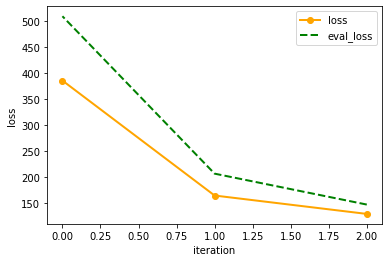

In [10]:
import google.datalab.bigquery as bq
df = bq.Query("SELECT iteration, loss, eval_loss FROM ML.TRAINING_INFO(MODEL model.candy_model_asis)").execute().result().to_dataframe()
# plot both lines in same graph
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( 'iteration', 'loss', data=df, marker='o', color='orange', linewidth=2)
plt.plot( 'iteration', 'eval_loss', data=df, marker='', color='green', linewidth=2, linestyle='dashed')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();
plt.show()

As you can see, the training loss is less then the evaluation loss. We do  seem to do some overfitting.

## Feature statistics

see information about the input features used to train a model.

We have the following columns:

- input — The name of the column in the input training data.
- min — The sample minimum. This column is NULL for non-numeric inputs.
- max — The sample maximum. This column is NULL for non-numeric inputs.
- mean — The average. This column is NULL for non-numeric inputs.
- stddev — The standard deviation. This column is NULL for non-numeric inputs.
- category_count — The number of categories. This column is NULL for non-categorical columns.
- null_count — The number of NULLs.

In [19]:
%%bq query
SELECT *
FROM ML.FEATURE_INFO(MODEL model.candy_model_asis)

input,min,max,mean,median,stddev,category_count,null_count
chocolate,,,,,,2,0
fruity,,,,,,2,0
peanutyalmondy,,,,,,2,0
crispedricewafer,,,,,,2,0
hard,,,,,,2,0
bar,,,,,,2,0
pricepercent,0.011,0.97600001,0.46604477570149255,0.465,0.29466249154794855,,0


## Weights information

returns the following columns:

- processed_input — The name of the model feature input. The value of this column matches the name of the column in the SELECT statement used during training.
- weight — The weight of each feature. For numerical columns, weight contains a value and the category_weights column is NULL. For non-numeric columns that are converted to one-hot encoding, the weight column is NULL and the category_weights column is an ARRAY of category names and weights for each category.
- category_weights.category — The category name if the input column is non-numeric.
- category_weights.weight — The category's weight if the input column is non-numeric.
- class_label — For multiclass models, class_label is the label for a given weight. The output includes one row per <class_label, processed_input> combination.

The following example retrieves weight information from our model.

The query returns the weights associated with each one-hot encoded category for the input column chocolate.

In [24]:
%%bq query
SELECT
  category,
  weight
FROM
  UNNEST((
    SELECT
      category_weights
    FROM
      ML.WEIGHTS(MODEL model.candy_model_asis)
    WHERE
      processed_input = 'chocolate'))

category,weight
1,10.662215874767389
0,5.019207737832014


This command uses the UNNEST function because the category_weights column is a nested repeated column.

The following query retrieves standardized weights, which assume all features have a mean of zero and a standard deviation of one.

In [26]:
%%bq query
SELECT
  *
FROM
  ML.WEIGHTS(MODEL model.candy_model_asis,
    STRUCT(true AS standardize))

processed_input,weight
chocolate,
fruity,
peanutyalmondy,
crispedricewafer,
hard,
bar,
pricepercent,1.130568938280931
__INTERCEPT__,7.293255793014927


## Evaluate Model Metrics

The following columns for a linear regression model:
- mean_absolute_error
- mean_squared_error
- mean_squared_log_error
- median_absolute_error
- r2_score
- explained_variance

In [14]:
%%bq query
SELECT *
FROM ML.EVALUATE(MODEL model.candy_model_asis)

mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
9.901469903630021,146.6701840272341,0.0474758525371477,9.102376639432364,0.26496429691277334,0.2651489459895693


## Make a Prediction with BQML using the Model

With a trained model, it is now possible to make a prediction on the values. The only difference from the second query above is the reference to the model. The data has been limited (LIMIT 100) to reduce amount of data returned.

When the ml.predict function is leveraged, output prediction column name for the model is predicted_<label_column_name>.

In [11]:
%%bq query
SELECT
  *
FROM
  ML.PREDICT(MODEL model.candy_model_asis,
      (SELECT
        winpercent,
        CAST(chocolate AS STRING) AS chocolate,
        CAST(fruity AS STRING) AS fruity,
        #CAST(caramel AS STRING) AS caramel,
        CAST(peanutyalmondy AS STRING) AS peanutyalmondy,
        #CAST(nougat AS STRING) AS nougat,
        CAST(crispedricewafer AS STRING) AS crispedricewafer,
        CAST(hard AS STRING) AS hard,
        CAST(bar AS STRING) AS bar,
        #CAST(pluribus AS STRING) AS pluribus,
        #sugarpercent, -- this is the label; because it is continuous, we need to use regression
        pricepercent
       FROM
        lidldatascientistadvanalytics.candy_data.original
      ))
LIMIT 100

predicted_winpercent,winpercent,chocolate,fruity,peanutyalmondy,crispedricewafer,hard,bar,pricepercent
47.150847848025485,32.261086,0,0,0,0,0,0,0.116
48.66639434891741,46.116505,0,0,0,0,0,0,0.51099998
46.31822763933578,52.341465,0,1,0,0,0,0,0.51099998
45.60457789684609,34.517681,0,1,0,0,0,0,0.32499999
41.532852500384344,39.460556,0,1,0,0,1,0,0.034000002
42.64936904697503,39.185505,0,1,0,0,1,0,0.32499999
44.80268113844386,41.389557,0,1,0,0,0,0,0.116
41.80143036722713,39.141056,0,1,0,0,1,0,0.104
45.428083941757535,52.911392,0,1,0,0,0,0,0.27900001
59.31322942878005,46.296597,0,0,1,0,0,1,0.76700002


Perhaps it is of interest to make a prediction of the popularity of a candy, given a number of other factors: chocolate, fruity, peanutyalmondy, crispedricewafer, hard, bar, pricepercent.

To make this prediction, these values will be passed into the SELECT statement.


In [12]:
%%bq query
SELECT
  *
FROM
  ml.PREDICT(MODEL model.candy_model_asis,
      (SELECT
          '1' AS chocolate,
          '1' AS fruity,
          '1' AS peanutyalmondy,
          '1' AS crispedricewafer,
          '1' AS hard,
          '1' AS bar,
          0.5 AS pricepercent
      ))

predicted_winpercent,chocolate,fruity,peanutyalmondy,crispedricewafer,hard,bar,pricepercent
62.74889115964341,1,1,1,1,1,1,0.5
